In [1]:
!pip install iterative-stratification



In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

2025-04-10 19:14:49.908643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744312490.374058      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744312490.495050      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# Load the preprocessed dataset
df = pd.read_csv("/kaggle/input/newmal2/anime_dataset_preprocessed.csv")

sbert_model = SentenceTransformer('all-mpnet-base-v2')

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Preprocess synopses and get embeddings
synopses = df['synopsis'].tolist()

# Generate SBERT embeddings
sbert_embeddings = sbert_model.encode(synopses, convert_to_tensor=True, show_progress_bar=True)

# Generate TF-IDF embeddings
tfidf_embeddings = tfidf_vectorizer.fit_transform(synopses).toarray()

# Prepare multi-label target variable (genres)
genres = df['combined'].str.split(',').apply(lambda x: [g.strip() for g in x])  # Split and clean genres

# MultiLabelBinarizer for multi-label classification
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(genres)  # Convert genres to one-hot encoded format


Batches:   0%|          | 0/338 [00:00<?, ?it/s]

In [10]:
# Model Architecture
class GenrePredictionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GenrePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Added dropout for regularization
        self.fc2 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x  # Return logits


criterion = nn.BCEWithLogitsLoss()

# make sure using gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
# Function to print the modified classification report and ROC-AUC
def print_classification_report_without_precision(y_true, y_scores, feature_name, mlb):
    # Generate the classification report as a dictionary
    y_scores_np = y_scores.cpu().numpy() if isinstance(y_scores, torch.Tensor) else y_scores
    report_dict = classification_report(
        y_true, (y_scores_np > 0.5).astype(int), target_names=mlb.classes_ if hasattr(mlb, 'classes_') else None, output_dict=True, zero_division=0
    )

    output = f"Classification Report for {feature_name}:\n"
    output += "              recall    f1-score   support\n"
    output += "-----------------------------------------\n"

    if hasattr(mlb, 'classes_'):
        for label in mlb.classes_:
            if str(label) in report_dict:
                output += f"{label:<15} {report_dict[str(label)]['recall']:.2f}    {report_dict[str(label)]['f1-score']:.2f}    {report_dict[str(label)]['support']:>7}\n"
    else:
        # Handle binary or multi-class without MultiLabelBinarizer names
        labels = [str(i) for i in range(len(report_dict) - 3) if str(i) in report_dict] # Exclude 'accuracy', 'macro avg', 'weighted avg'
        for label in labels:
            output += f"{label:<15} {report_dict[label]['recall']:.2f}    {report_dict[label]['f1-score']:.2f}    {report_dict[label]['support']:>7}\n"

    output += "\n"
    if 'macro avg' in report_dict:
        output += f"{'macro avg':<15} {report_dict['macro avg']['recall']:.2f}    {report_dict['macro avg']['f1-score']:.2f}    {report_dict['macro avg']['support']:>7}\n"
    if 'weighted avg' in report_dict:
        output += f"{'weighted avg':<15} {report_dict['weighted avg']['recall']:.2f}    {report_dict['weighted avg']['f1-score']:.2f}    {report_dict['weighted avg']['support']:>7}\n"
    if 'accuracy' in report_dict:
        output += f"{'accuracy':<15}                        {report_dict['accuracy']:.2f}    {report_dict.get('weighted avg', {}).get('support', sum(report_dict[str(i)]['support'] for i in range(len(report_dict) - 3) if str(i) in report_dict)):>7}\n"

    print(output)

    # Plot ROC curve for each class
    n_classes = y_true.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc_class = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc_class[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{mlb.classes_[i]} (AUC = {roc_auc_class[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {feature_name} Model')
    plt.legend(loc="lower right")
    plt.show()


--- Processing tfidf embeddings ---


Feature: tfidf, Fold 1, Epoch 1: Train Loss=0.4252, Val Loss=0.3616


Feature: tfidf, Fold 1, Epoch 2: Train Loss=0.3261, Val Loss=0.3207


Feature: tfidf, Fold 1, Epoch 3: Train Loss=0.2740, Val Loss=0.2992


Feature: tfidf, Fold 1, Epoch 4: Train Loss=0.2338, Val Loss=0.2912


Feature: tfidf, Fold 1, Epoch 5: Train Loss=0.2008, Val Loss=0.2919


Feature: tfidf, Fold 1, Epoch 6: Train Loss=0.1742, Val Loss=0.2986


Fold 1 testing: 100%|██████████| 69/69 [00:00<00:00, 948.88it/s]


Feature: tfidf, Fold 1: Test Loss=0.2898


Feature: tfidf, Fold 2, Epoch 1: Train Loss=0.4225, Val Loss=0.3645


Feature: tfidf, Fold 2, Epoch 2: Train Loss=0.3236, Val Loss=0.3235


Feature: tfidf, Fold 2, Epoch 3: Train Loss=0.2729, Val Loss=0.3034


Feature: tfidf, Fold 2, Epoch 4: Train Loss=0.2328, Val Loss=0.2953


Feature: tfidf, Fold 2, Epoch 5: Train Loss=0.2004, Val Loss=0.2959


Feature: tfidf, Fold 2, Epoch 6: Train Loss=0.1736, Val Loss=0.3035


Fold 2 testing: 100%|██████████| 68/68 [00:00<00:00, 1069.60it/s]


Feature: tfidf, Fold 2: Test Loss=0.2954


Feature: tfidf, Fold 3, Epoch 1: Train Loss=0.4234, Val Loss=0.3606


Feature: tfidf, Fold 3, Epoch 2: Train Loss=0.3250, Val Loss=0.3199


Feature: tfidf, Fold 3, Epoch 3: Train Loss=0.2730, Val Loss=0.2981


Feature: tfidf, Fold 3, Epoch 4: Train Loss=0.2321, Val Loss=0.2894


Feature: tfidf, Fold 3, Epoch 5: Train Loss=0.2001, Val Loss=0.2891


Feature: tfidf, Fold 3, Epoch 6: Train Loss=0.1737, Val Loss=0.2928


Fold 3 testing: 100%|██████████| 67/67 [00:00<00:00, 973.97it/s]


Feature: tfidf, Fold 3: Test Loss=0.3017


Feature: tfidf, Fold 4, Epoch 1: Train Loss=0.4256, Val Loss=0.3591


Feature: tfidf, Fold 4, Epoch 2: Train Loss=0.3270, Val Loss=0.3162


Feature: tfidf, Fold 4, Epoch 3: Train Loss=0.2739, Val Loss=0.2952


Feature: tfidf, Fold 4, Epoch 4: Train Loss=0.2327, Val Loss=0.2878


Feature: tfidf, Fold 4, Epoch 5: Train Loss=0.2012, Val Loss=0.2888


Feature: tfidf, Fold 4, Epoch 6: Train Loss=0.1747, Val Loss=0.2937


Fold 4 testing: 100%|██████████| 67/67 [00:00<00:00, 1065.77it/s]


Feature: tfidf, Fold 4: Test Loss=0.3010


Feature: tfidf, Fold 5, Epoch 1: Train Loss=0.4258, Val Loss=0.3635


Feature: tfidf, Fold 5, Epoch 2: Train Loss=0.3257, Val Loss=0.3242


Feature: tfidf, Fold 5, Epoch 3: Train Loss=0.2734, Val Loss=0.3060


Feature: tfidf, Fold 5, Epoch 4: Train Loss=0.2332, Val Loss=0.3001


Feature: tfidf, Fold 5, Epoch 5: Train Loss=0.2012, Val Loss=0.3020


Feature: tfidf, Fold 5, Epoch 6: Train Loss=0.1751, Val Loss=0.3078


Fold 5 testing: 100%|██████████| 70/70 [00:00<00:00, 1037.71it/s]


Feature: tfidf, Fold 5: Test Loss=0.2909
Classification Report for tfidf:
              recall    f1-score   support
-----------------------------------------
Action          0.64    0.68       3628
Adventure       0.46    0.54       2593
Comedy          0.54    0.60       3958
Drama           0.28    0.36       2078
Everyday Life   0.10    0.17        861
Fantasy         0.53    0.61       2913
Fighting Robots 0.43    0.55        853
Historical      0.29    0.41        891
Lewd            0.03    0.06        553
Music           0.34    0.49        545
Mystery         0.28    0.42        689
Romance         0.30    0.41       1583
School          0.50    0.60       1481
Science Fiction 0.57    0.66       2259
Supernatural    0.24    0.35        950

macro avg       0.37    0.46      25835
weighted avg    0.45    0.53      25835



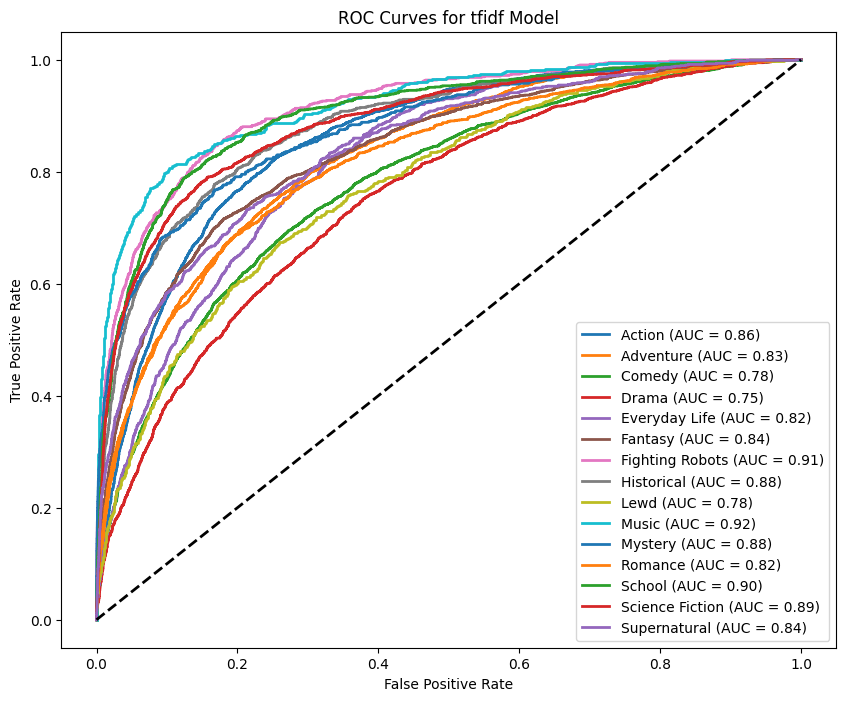

--- Processing sbert embeddings ---


Feature: sbert, Fold 1, Epoch 1: Train Loss=0.3816, Val Loss=0.3233


Feature: sbert, Fold 1, Epoch 2: Train Loss=0.3125, Val Loss=0.3023


Feature: sbert, Fold 1, Epoch 3: Train Loss=0.2963, Val Loss=0.2950


Feature: sbert, Fold 1, Epoch 4: Train Loss=0.2882, Val Loss=0.2932


Feature: sbert, Fold 1, Epoch 5: Train Loss=0.2829, Val Loss=0.2896


Feature: sbert, Fold 1, Epoch 6: Train Loss=0.2782, Val Loss=0.2885


Fold 1 testing: 100%|██████████| 69/69 [00:00<00:00, 1547.04it/s]


Feature: sbert, Fold 1: Test Loss=0.2787


Feature: sbert, Fold 2, Epoch 1: Train Loss=0.3784, Val Loss=0.3235


Feature: sbert, Fold 2, Epoch 2: Train Loss=0.3090, Val Loss=0.3040


Feature: sbert, Fold 2, Epoch 3: Train Loss=0.2939, Val Loss=0.2965


Feature: sbert, Fold 2, Epoch 4: Train Loss=0.2865, Val Loss=0.2925


Feature: sbert, Fold 2, Epoch 5: Train Loss=0.2808, Val Loss=0.2905


Feature: sbert, Fold 2, Epoch 6: Train Loss=0.2770, Val Loss=0.2881


Fold 2 testing: 100%|██████████| 68/68 [00:00<00:00, 1580.52it/s]


Feature: sbert, Fold 2: Test Loss=0.2863


Feature: sbert, Fold 3, Epoch 1: Train Loss=0.3787, Val Loss=0.3225


Feature: sbert, Fold 3, Epoch 2: Train Loss=0.3089, Val Loss=0.2983


Feature: sbert, Fold 3, Epoch 3: Train Loss=0.2934, Val Loss=0.2923


Feature: sbert, Fold 3, Epoch 4: Train Loss=0.2861, Val Loss=0.2888


Feature: sbert, Fold 3, Epoch 5: Train Loss=0.2802, Val Loss=0.2858


Feature: sbert, Fold 3, Epoch 6: Train Loss=0.2758, Val Loss=0.2843


Fold 3 testing: 100%|██████████| 67/67 [00:00<00:00, 1584.98it/s]


Feature: sbert, Fold 3: Test Loss=0.2913


Feature: sbert, Fold 4, Epoch 1: Train Loss=0.3781, Val Loss=0.3223


Feature: sbert, Fold 4, Epoch 2: Train Loss=0.3077, Val Loss=0.3010


Feature: sbert, Fold 4, Epoch 3: Train Loss=0.2922, Val Loss=0.2935


Feature: sbert, Fold 4, Epoch 4: Train Loss=0.2850, Val Loss=0.2904


Feature: sbert, Fold 4, Epoch 5: Train Loss=0.2795, Val Loss=0.2887


Feature: sbert, Fold 4, Epoch 6: Train Loss=0.2755, Val Loss=0.2865


Fold 4 testing: 100%|██████████| 67/67 [00:00<00:00, 1468.75it/s]


Feature: sbert, Fold 4: Test Loss=0.2904


Feature: sbert, Fold 5, Epoch 1: Train Loss=0.3777, Val Loss=0.3256


Feature: sbert, Fold 5, Epoch 2: Train Loss=0.3090, Val Loss=0.3039


Feature: sbert, Fold 5, Epoch 3: Train Loss=0.2934, Val Loss=0.2969


Feature: sbert, Fold 5, Epoch 4: Train Loss=0.2863, Val Loss=0.2924


Feature: sbert, Fold 5, Epoch 5: Train Loss=0.2800, Val Loss=0.2904


Feature: sbert, Fold 5, Epoch 6: Train Loss=0.2763, Val Loss=0.2891


Fold 5 testing: 100%|██████████| 70/70 [00:00<00:00, 1579.25it/s]


Feature: sbert, Fold 5: Test Loss=0.2869
Classification Report for sbert:
              recall    f1-score   support
-----------------------------------------
Action          0.69    0.70       3628
Adventure       0.41    0.51       2593
Comedy          0.47    0.56       3958
Drama           0.14    0.23       2078
Everyday Life   0.06    0.11        861
Fantasy         0.53    0.60       2913
Fighting Robots 0.37    0.48        853
Historical      0.29    0.41        891
Lewd            0.00    0.00        553
Music           0.43    0.56        545
Mystery         0.22    0.34        689
Romance         0.26    0.37       1583
School          0.49    0.58       1481
Science Fiction 0.60    0.67       2259
Supernatural    0.19    0.30        950

macro avg       0.34    0.43      25835
weighted avg    0.42    0.50      25835



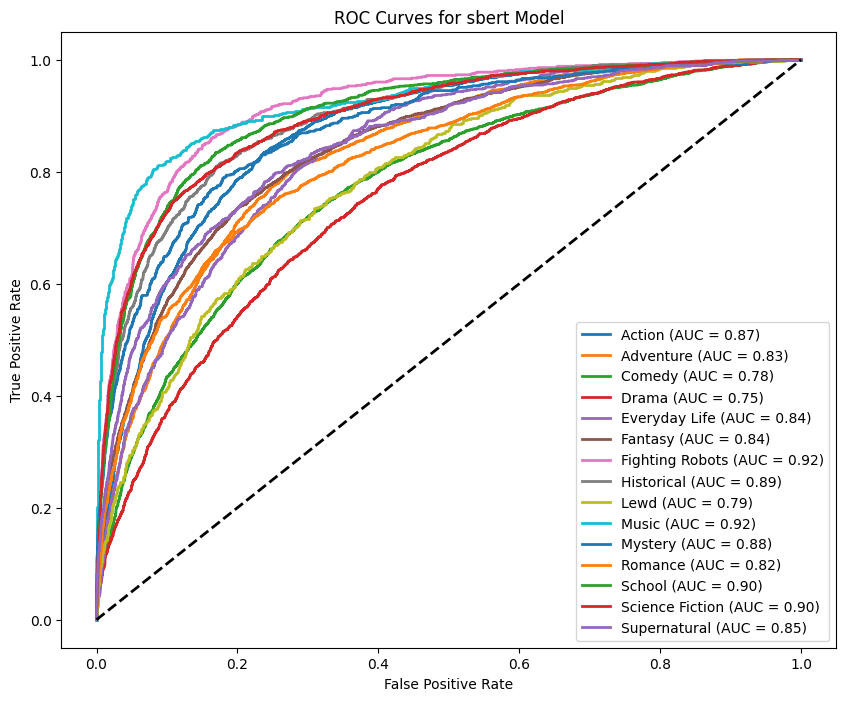

K-fold cross-validation complete.


In [30]:
# Number of folds and training hyperparameters
num_folds = 5
num_epochs = 6 
batch_size = 32
learning_rate = 1e-3

# Prepare both features sets in a dict: key is a string for identification
X_features = {
    'tfidf': torch.tensor(tfidf_embeddings, dtype=torch.float32),
    'sbert': sbert_embeddings 
}

# target variable (genres) is stored in y (numpy array)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Multilabel StratifiedKFold splitter (from iterstrat)
mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

results = {} 


# Loop over each feature type
for feat_name, X in X_features.items():
    print(f"--- Processing {feat_name} embeddings ---")
    fold_results = []

    # Loop over each fold
    for fold, (train_val_idx, test_idx) in enumerate(mskf.split(X, y_tensor), 1):
        # Further split train_val into training and validation sets (e.g., 80-20 split)
        train_val_idx = np.array(train_val_idx)
        test_idx = np.array(test_idx)
        num_train = int(0.8 * len(train_val_idx))  # 80% training, 20% validation

        # Shuffle train_val indices
        np.random.shuffle(train_val_idx)
        train_idx = train_val_idx[:num_train]
        val_idx = train_val_idx[num_train:]

        # Create datasets for train, validation, and test
        train_dataset = TensorDataset(X[train_idx], y_tensor[train_idx])
        val_dataset = TensorDataset(X[val_idx], y_tensor[val_idx])
        test_dataset = TensorDataset(X[test_idx], y_tensor[test_idx])

        # Create dataloaders for each set
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # model, optimizer, and criterion
        input_dim = X.shape[1]
        output_dim = y_tensor.shape[1]
        model = GenrePredictionModel(input_dim, output_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

        # Training loop for current fold
        for epoch in range(1, num_epochs + 1):
            model.train()
            train_loss = 0.0
            for batch_X, batch_y in tqdm(train_loader, desc=f"Fold {fold} Epoch {epoch} training", leave=False):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                logits = model(batch_X)
                loss = criterion(logits, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)
            train_loss /= len(train_loader.dataset)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_X, batch_y in tqdm(val_loader, desc=f"Fold {fold} Epoch {epoch} validation", leave=False):
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    logits = model(batch_X)
                    loss = criterion(logits, batch_y)
                    val_loss += loss.item() * batch_X.size(0)
            val_loss /= len(val_loader.dataset)

            scheduler.step(val_loss)
            print(f"Feature: {feat_name}, Fold {fold}, Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

        # Testing phase
        model.eval()
        test_loss = 0.0
        all_logits = []
        all_targets = []
        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader, desc=f"Fold {fold} testing"):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                logits = model(batch_X)
                loss = criterion(logits, batch_y)
                test_loss += loss.item() * batch_X.size(0)
                all_logits.append(logits)
                all_targets.append(batch_y)
        test_loss /= len(test_loader.dataset)

        # Concatenate results
        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        print(f"Feature: {feat_name}, Fold {fold}: Test Loss={test_loss:.4f}")
        fold_results.append({
            'fold': fold,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'test_loss': test_loss,
            'logits': all_logits,
            'targets': all_targets,
            'test_idx': test_idx  
        })

    results[feat_name] = fold_results

    # After cross-validation, evaluate final model using the stored logits and targets
    y_true = np.concatenate([fold['targets'].cpu().numpy() for fold in fold_results], axis=0)
    y_scores = torch.sigmoid(torch.cat([fold['logits'] for fold in fold_results], dim=0)).cpu().numpy()

    # Print the classification report and ROC-AUC
    print_classification_report_without_precision(y_true, y_scores, feat_name, mlb)

print("K-fold cross-validation complete.")

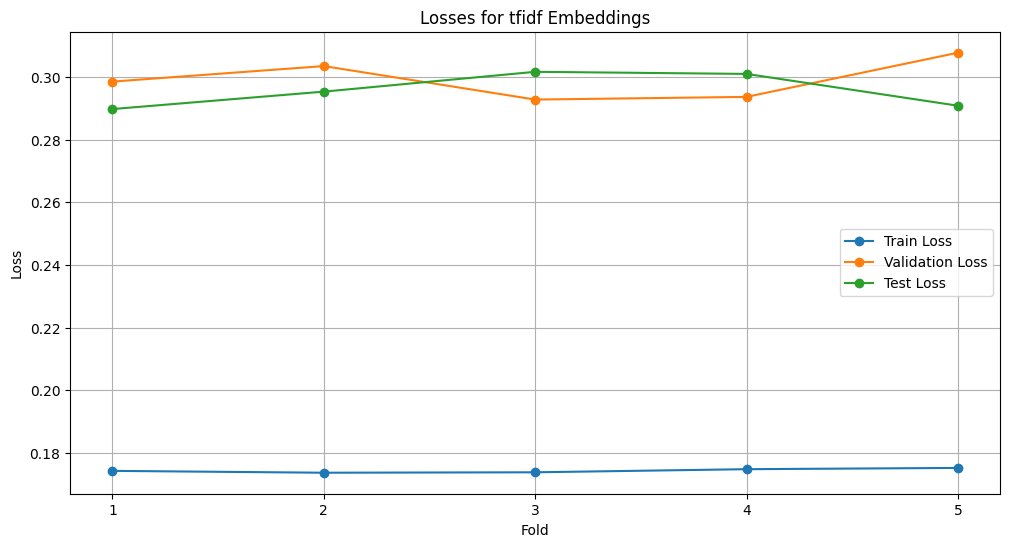

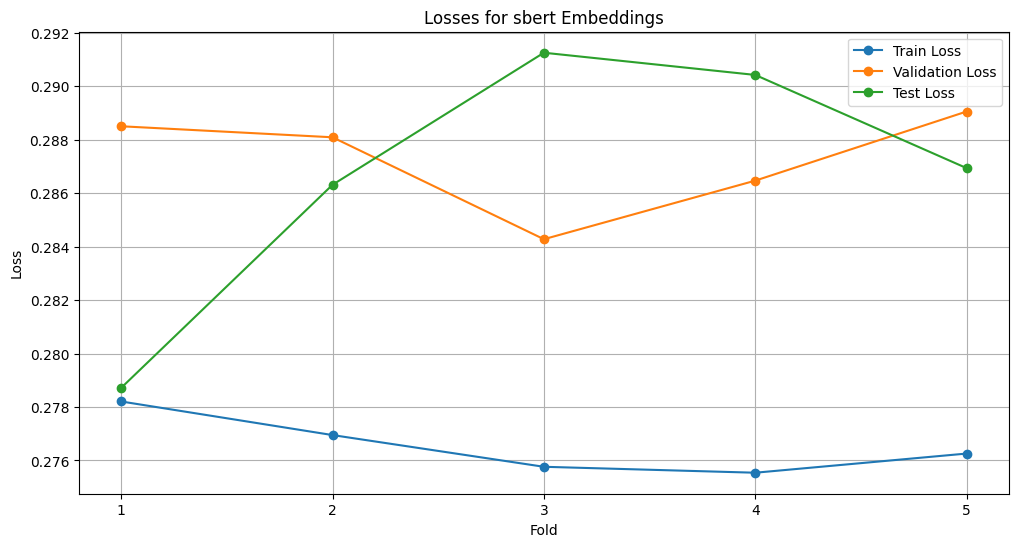

In [31]:
# Visualize losses for each fold and feature type
def plot_losses(results, feature_name):
    # Extract losses for each fold and feature type
    train_losses = [fold['train_loss'] for fold in results[feature_name]]
    val_losses = [fold['val_loss'] for fold in results[feature_name]]
    test_losses = [fold['test_loss'] for fold in results[feature_name]]

    # Plot the losses for each fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_folds + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_folds + 1), val_losses, label='Validation Loss', marker='o')
    plt.plot(range(1, num_folds + 1), test_losses, label='Test Loss', marker='o')
    plt.title(f'Losses for {feature_name} Embeddings')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.xticks(range(1, num_folds + 1))
    plt.legend()
    plt.grid()
    plt.show()

# Plot losses for both feature types
plot_losses(results, 'tfidf')
plot_losses(results, 'sbert')

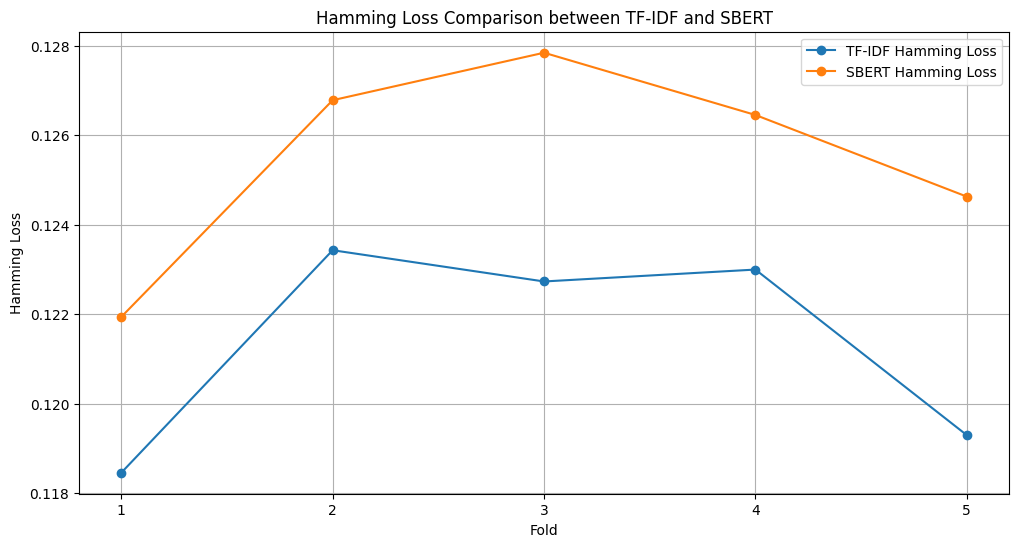

In [32]:
def plot_hamming_loss_comparison(results):
    # Compute Hamming loss for each fold for both TF-IDF and SBERT
    hamming_losses_tfidf = [
        hamming_loss(fold['targets'].cpu().numpy(), (fold['logits'] > 0.5).cpu().numpy())
        for fold in results['tfidf']
    ]

    hamming_losses_sbert = [
        hamming_loss(fold['targets'].cpu().numpy(), (fold['logits'] > 0.5).cpu().numpy())
        for fold in results['sbert']
    ]

    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_folds + 1), hamming_losses_tfidf, label='TF-IDF Hamming Loss', marker='o')
    plt.plot(range(1, num_folds + 1), hamming_losses_sbert, label='SBERT Hamming Loss', marker='o')
    plt.title('Hamming Loss Comparison between TF-IDF and SBERT')
    plt.xlabel('Fold')
    plt.ylabel('Hamming Loss')
    plt.xticks(range(1, num_folds + 1))
    plt.legend()
    plt.grid()
    plt.show()

# Call the comparison function
plot_hamming_loss_comparison(results)

In [36]:
last_fold_sbert = results['sbert'][-1]
last_fold_tfidf = results['tfidf'][-1]


# Convert the logits to probabilities and then binary predictions
probs_sbert = torch.sigmoid(last_fold_sbert['logits']).cpu().numpy()
y_pred_sbert = (probs_sbert > 0.5).astype(int)
true_labels = last_fold_sbert['targets'].cpu().numpy()

probs_tfidf = torch.sigmoid(last_fold_tfidf['logits']).cpu().numpy()
y_pred_tfidf = (probs_tfidf > 0.5).astype(int)



test_indices_sbert = last_fold_sbert['test_idx']

for _ in range(5):
    # Pick a random index from the test indices
    orig_idx = random.choice(test_indices_sbert)
    print(f"Anime Title: {df.loc[orig_idx, 'title']}")
    print(f"Synopsis (Preprocessed): {df.loc[orig_idx, 'synopsis']}")
    original_genres = [genre.strip() for genre in df.loc[orig_idx, 'combined'].split(',')]
    print(f"Original Genres: {', '.join(original_genres)}")

    # Now, find the local position in the current test fold
    local_idx = list(test_indices_sbert).index(orig_idx)


    sbert_pred_genres = mlb.classes_[y_pred_sbert[local_idx] == 1]
    true_genres = mlb.classes_[true_labels[local_idx] == 1]
    tfidf_pred_genres = mlb.classes_[y_pred_tfidf[local_idx] == 1]
    print(f"Predicted Genres (SBERT): {', '.join(sbert_pred_genres)}")
    print(f"Predicted Genres (TF-IDF): {', '.join(tfidf_pred_genres)}")
    print("-" * 80)


Anime Title: Xian Wu Chuan
Synopsis (Preprocessed): loyal disciple ye chen dedicated guard spiritual medicine field sect fight enemy spiritual field destroyed loyalty dedicating sect could save loyalty thought obtained peer lover could save betrayal thus shamelessly banished sect help flame falling heaven ye chen began develop stronger cultivator battled opponent unfolded legendary life rewrote story
Original Genres: Action, Adventure, Fantasy, Historical
Predicted Genres (SBERT): Action, Adventure, Fantasy
Predicted Genres (TF-IDF): Action, Adventure, Fantasy, Historical
--------------------------------------------------------------------------------
Anime Title: Non Non Biyori: Okinawa e Ikukoto ni Natta
Synopsis (Preprocessed): spending summer day department store suguru koshigaya win lottery grand prizefour ticket okinawa filled awe excitement girl asahigaoka various thing prepare trip practicing ride airplane buying travel essential convenience store everything beforehand enjoy ti